In [46]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import mplleaflet, pydotplus
from math import radians, cos, sin, asin, sqrt
from ibmgeohashpy import geohash
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import ListedColormap
import os, sys, json, re, itertools, warnings, folium
from matplotlib import animation
from IPython.display import Image
%matplotlib inline
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from scipy.interpolate import spline
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
print('Libraries imported..')

Libraries imported..


In [47]:
datadir = './data'
#traj_len = pd.read_csv(os.path.join(datadir,'devices_traj_len_more_than_5_km'))
#gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'))
freq_geo = pd.read_csv('formatted_freqItemSets_train_geohash_6_05022017.csv')
freq_geo['geohashes_int'] = freq_geo['geohash_6'].map(lambda x: geohash.base32_to_int(x))
freq_geo = freq_geo[['geohashes_int','device_id','age','group','gender','freq']]
freq_geo.head()

,geohashes_int,device_id,age,group,gender,freq
0,1926613402,-8340098378141160000,28,3,0,3745
1,1941428601,-3746248670824160000,46,6,0,2592
2,1938134119,5375599021847300000,47,12,1,2444
3,959434969,-6242501228649110000,20,1,0,2441
4,965974353,1779631023439410000,39,11,1,2233


In [65]:
?sns.pairplot

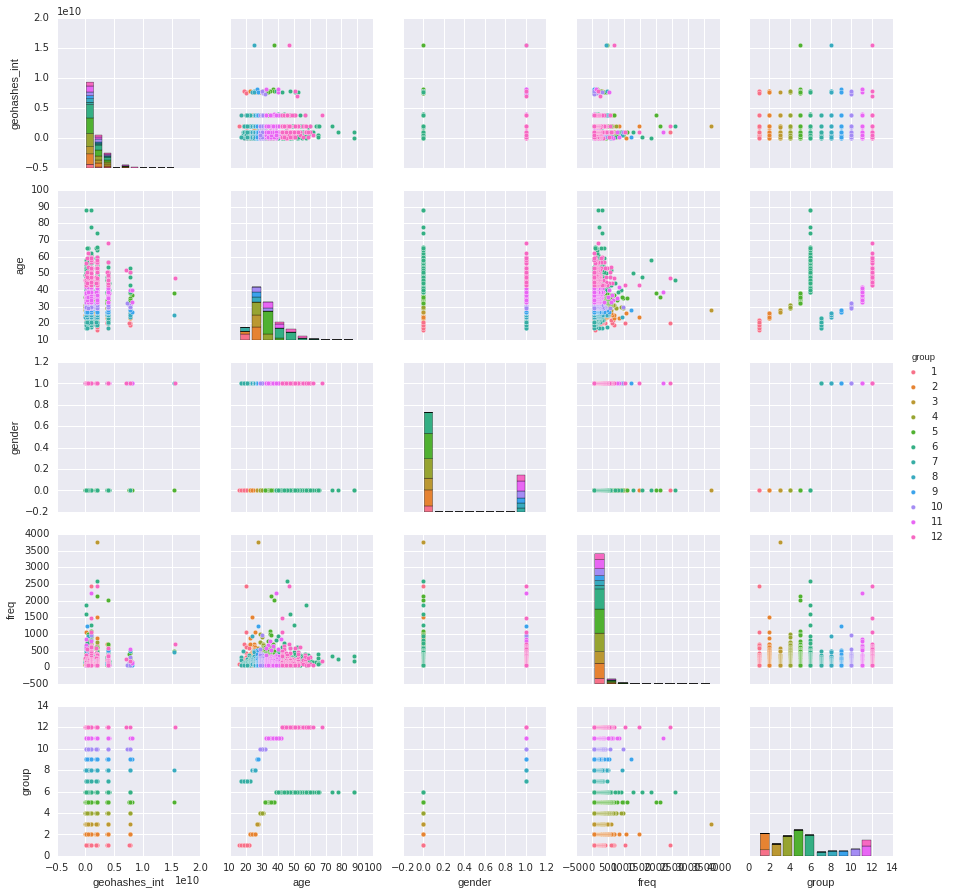

In [64]:
import seaborn as sns
sns.pairplot(freq_geo[['geohashes_int','age','gender','freq','group']], hue='group')

In [48]:
lda_features_new = freq_geo[['geohashes_int','device_id','freq','gender','group','age']].dropna().drop_duplicates()
print(lda_features_new.shape)
lda_features_new.head()

(2279, 6)


,geohashes_int,device_id,freq,gender,group,age
0,1926613402,-8340098378141160000,3745,0,3,28
1,1941428601,-3746248670824160000,2592,0,6,46
2,1938134119,5375599021847300000,2444,1,12,47
3,959434969,-6242501228649110000,2441,0,1,20
4,965974353,1779631023439410000,2233,1,11,39


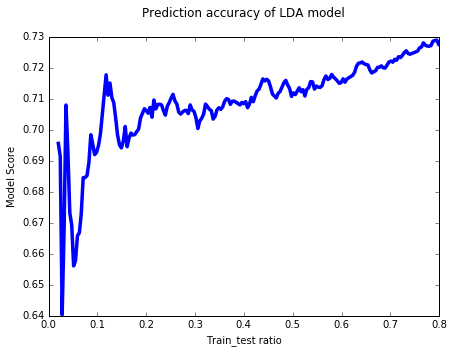

In [49]:
# Including features : geohash, device_id, event_id, traj_len,freq
#lda_features = train_lda[['geohashes_int','device_id','freq','age_y','gender_y']].dropna(how='any')
X = lda_features_new[['geohashes_int','device_id','freq','age']].values
y = np.array(lda_features_new['gender'].tolist())
test_size = np.arange(0.02,0.8,0.001)
train_test_ratio,test_set,score,rmse=[],[],[],[]
#print('Features Selected:',lda_features.columns[0:len(lda_features.columns)-1])
#print('\nClass Labels: Male=0, Female = 1')
clf = LDA(store_covariance = False,solver ='lsqr',shrinkage='auto')
for i in test_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state = 0)
    # Fit the data to LDA model
    fit = clf.fit(X_train,y_train)
    # Predict confidence scores for samples.
    decision_func = fit.decision_function(X_test)
    #print('\ntrain_test_split = ',(1-i)*100,':',i*100)
    #print('\nModel Parameters:',clf.get_params(deep=True))
    #print('\nPredicted Classes: ',clf.predict(X_test))
    #print('\nModel Score:',fit.score(X_test,y_test))
    #features_samples_ratio.append(len(X) / len(X_train))
    score.append(fit.score(X_test,y_test))
    train_test_ratio.append(len(X_train)/len(X_test))
    test_set.append(i)
    y_pred = fit.predict(X_test)
    rmse.append(mean_squared_error(y_test, y_pred))

xnew = np.linspace(np.array(test_size).min(),np.array(test_size).max(),200)
power_smooth = spline(np.array(test_set),np.array(score),xnew)
plt.figure(figsize=(7,5))
plt.plot(xnew,power_smooth,'b-',lw=3.5)   
plt.xlabel('Train_test ratio')
plt.ylabel('Model Score')
plt.title('Prediction accuracy of LDA model\n')
plt.savefig('LDA_model_accuracy_05022017.png')

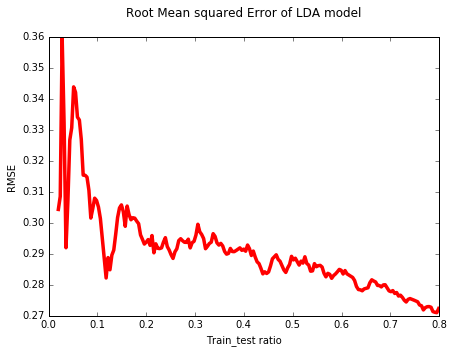

In [50]:
xnew1 = np.linspace(np.array(test_size).min(),np.array(test_size).max(),200)
power_smooth1 = spline(np.array(test_set),np.array(rmse),xnew)
plt.figure(figsize=(7,5))
plt.plot(xnew1,power_smooth1,'r-',lw=3.5)
plt.xlabel('Train_test ratio')
plt.ylabel('RMSE')
plt.title('Root Mean squared Error of LDA model\n')
#plt.show()
plt.savefig('LDA_model_rmse_15022017.png')

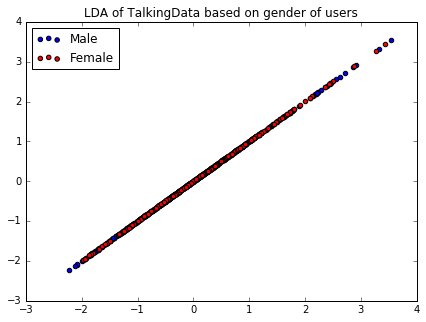

In [61]:
fitted = []
#for item in np.arange(0.20,0.85,0.003):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.64, random_state = 0)
X_r2 = LDA().fit(X_train,y_train).transform(X_train)#.transform(X_train)
#fitted.append(X_r2)
plt.figure(figsize=(7,5))
for c, i, target_name in zip("br", [0, 1],["Male","Female"]):
    #print(c,i,X_r2[y_train == i],)
    plt.scatter(X_r2[y_train == i], X_r2[y_train == i], c=c, label=target_name)
plt.legend(loc = 'upper left')
plt.title('LDA of TalkingData based on gender of users')
filename = 'LDA_model_05022017.eps'
plt.savefig(filename)

In [33]:
X_r2

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=0.0001)

In [38]:
df_M = lda_features_new.query('gender == 0')
df_F = lda_features_new.query('gender == 1')

In [41]:
(df_M.shape[0]/lda_features_new.shape[0])*100

72.88284335234752

In [ ]:
df_M['group'].unique()

In [ ]:
df_F['group'].unique()

0.999762305917


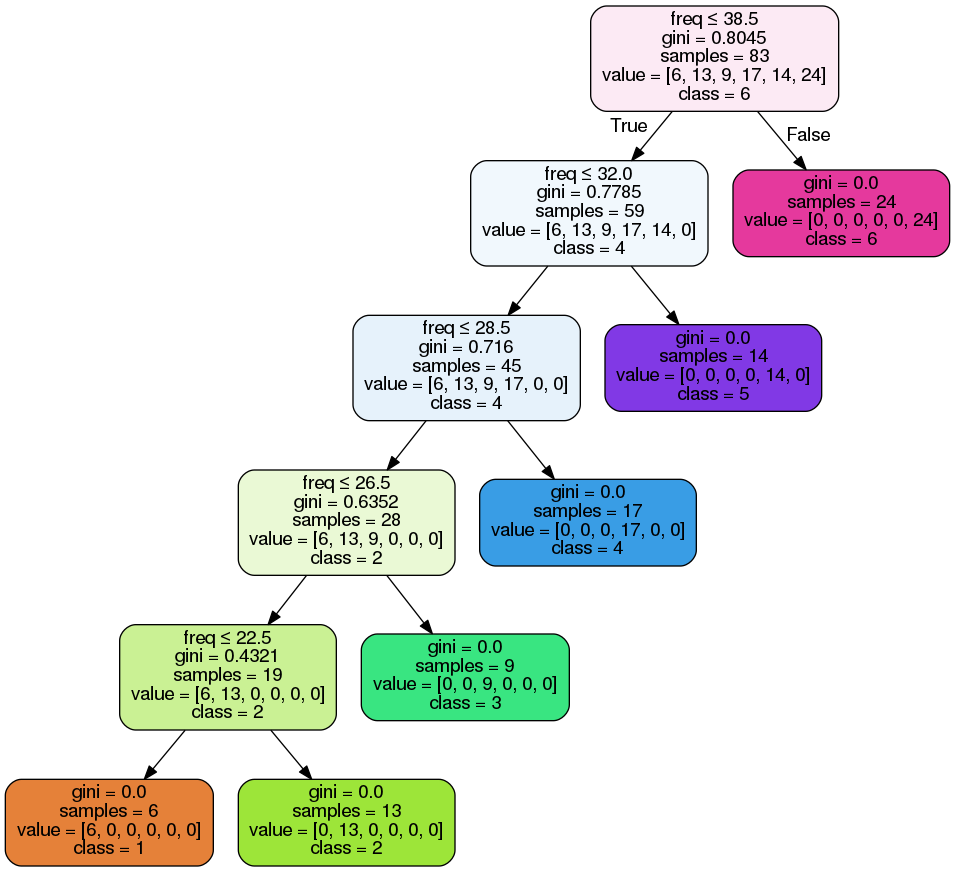

In [85]:
import pydotplus
from IPython.display import Image 
from sklearn import tree
X = df_M[['geohashes_int','device_id','freq','age']].values
y = df_M['group'].values
score_M = []
for i in np.arange(0.25,0.95,0.0001):
    X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X, y, test_size=i)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train_M,y_train_M)
    y_pred_M = clf.predict(X_test_M)
    score_M.append(clf.score(X_test_M,y_test_M))
    #print(clf.score(X_test_M,y_test_M))
print(np.mean(score_M))
features = ['geohash_int','device_id','age','freq']
classes = np.array(['1', '2', '3', '4','5','6'])
with open("Tree_df_M.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f,
                            feature_names=features,  
                            class_names=classes,  
                            filled=True, rounded=True,  
                            special_characters=True)

graph = pydotplus.graphviz.graph_from_dot_file("Tree_df_M.dot")
graph.write_pdf("Tree_df_M.pdf")
Image(graph.create_png())

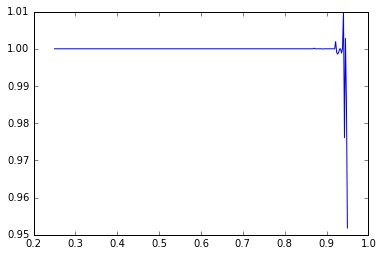

In [86]:
xnew = np.linspace(np.arange(0.25,0.95,0.0001).min(),np.arange(0.25,0.95,0.0001).max(),300)#np.array(test_set).max()
power_smooth = spline(np.arange(0.25,0.95,0.0001),np.array(score_M),xnew)

plt.plot(xnew,power_smooth,'b-')

0.999426845194


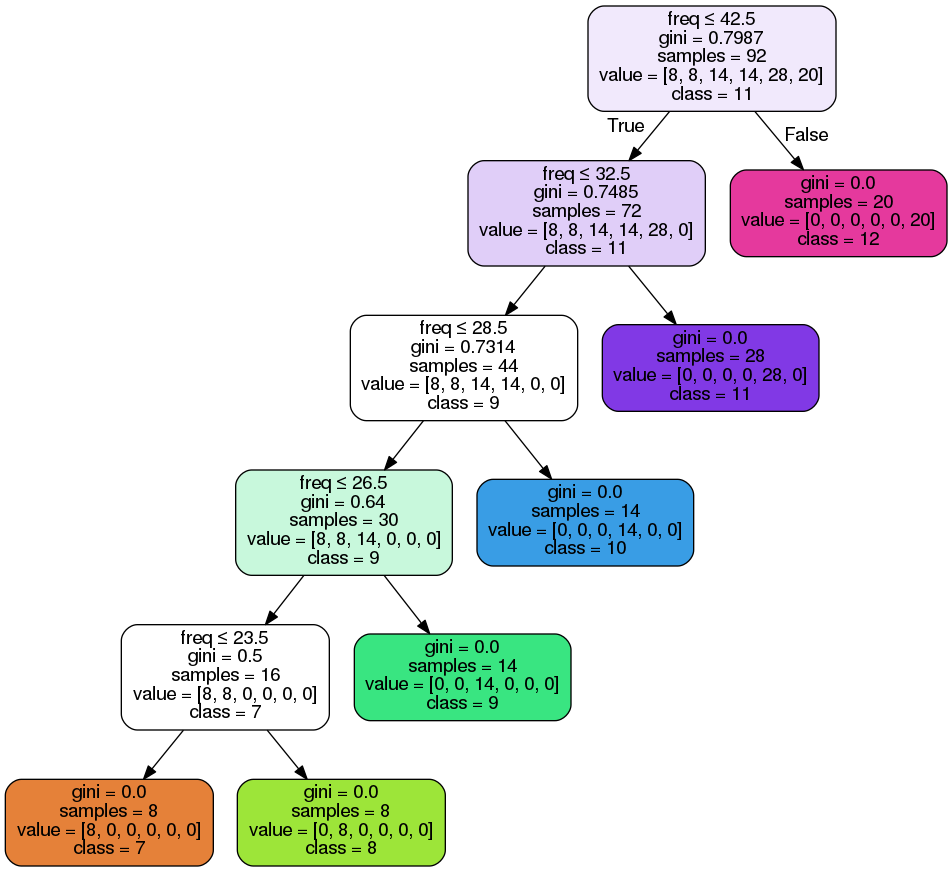

In [82]:
import pydotplus
from IPython.display import Image 
from sklearn import tree
X = df_F[['geohashes_int','device_id','freq','age','gender']].values
y = df_F['group'].values
score_F = []
for i in np.arange(0.25,0.85,0.0001):
    X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X, y, test_size=i)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train_F,y_train_F)
    y_pred_F = clf.predict(X_test_F)
    score_F.append(clf.score(X_test_F,y_test_F))
    
print(np.mean(score_F))
    
features = ['geohash_int','device_id','age','freq','gender']
classes = np.array(['7', '8', '9', '10','11','12'])
with open("Tree_df_F.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f,
                            feature_names=features,  
                            class_names=classes,  
                            filled=True, rounded=True,  
                            special_characters=True)

graph = pydotplus.graphviz.graph_from_dot_file("Tree_df_F.dot")
graph.write_pdf("Tree_df_F.pdf")
Image(graph.create_png())

In [46]:
for i in zip(np.arange(0.095,0.978,0.001),score_F):
    print(i)

(0.095000000000000001, 1.0)
(0.096000000000000002, 1.0)
(0.097000000000000003, 1.0)
(0.098000000000000004, 1.0)
(0.099000000000000005, 1.0)
(0.10000000000000001, 1.0)
(0.10100000000000001, 1.0)
(0.10200000000000001, 1.0)
(0.10300000000000001, 1.0)
(0.10400000000000001, 1.0)
(0.10500000000000001, 1.0)
(0.10600000000000001, 1.0)
(0.10700000000000001, 1.0)
(0.10800000000000001, 1.0)
(0.10900000000000001, 1.0)
(0.11000000000000001, 1.0)
(0.11100000000000002, 1.0)
(0.11200000000000002, 1.0)
(0.11300000000000002, 1.0)
(0.11400000000000002, 1.0)
(0.11500000000000002, 1.0)
(0.11600000000000002, 1.0)
(0.11700000000000002, 1.0)
(0.11800000000000002, 1.0)
(0.11900000000000002, 1.0)
(0.12000000000000002, 1.0)
(0.12100000000000002, 1.0)
(0.12200000000000003, 1.0)
(0.12300000000000003, 1.0)
(0.12400000000000003, 1.0)
(0.12500000000000003, 1.0)
(0.12600000000000003, 1.0)
(0.12700000000000003, 1.0)
(0.12800000000000003, 1.0)
(0.12900000000000003, 1.0)
(0.13000000000000003, 1.0)
(0.13100000000000003, 1

In [47]:
for i in zip(np.arange(0.095,0.978,0.001),score_M):
    print(i)

(0.095000000000000001, 1.0)
(0.096000000000000002, 1.0)
(0.097000000000000003, 1.0)
(0.098000000000000004, 1.0)
(0.099000000000000005, 1.0)
(0.10000000000000001, 1.0)
(0.10100000000000001, 1.0)
(0.10200000000000001, 1.0)
(0.10300000000000001, 1.0)
(0.10400000000000001, 1.0)
(0.10500000000000001, 1.0)
(0.10600000000000001, 1.0)
(0.10700000000000001, 1.0)
(0.10800000000000001, 1.0)
(0.10900000000000001, 1.0)
(0.11000000000000001, 1.0)
(0.11100000000000002, 1.0)
(0.11200000000000002, 1.0)
(0.11300000000000002, 1.0)
(0.11400000000000002, 1.0)
(0.11500000000000002, 1.0)
(0.11600000000000002, 1.0)
(0.11700000000000002, 1.0)
(0.11800000000000002, 1.0)
(0.11900000000000002, 1.0)
(0.12000000000000002, 1.0)
(0.12100000000000002, 1.0)
(0.12200000000000003, 1.0)
(0.12300000000000003, 1.0)
(0.12400000000000003, 1.0)
(0.12500000000000003, 1.0)
(0.12600000000000003, 1.0)
(0.12700000000000003, 1.0)
(0.12800000000000003, 1.0)
(0.12900000000000003, 1.0)
(0.13000000000000003, 1.0)
(0.13100000000000003, 1

Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.95  0.05  0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.47  0.53  0.  ]
 [ 0.    0.    0.    0.51  0.47  0.01]
 [ 0.    0.    0.    0.73  0.    0.27]]


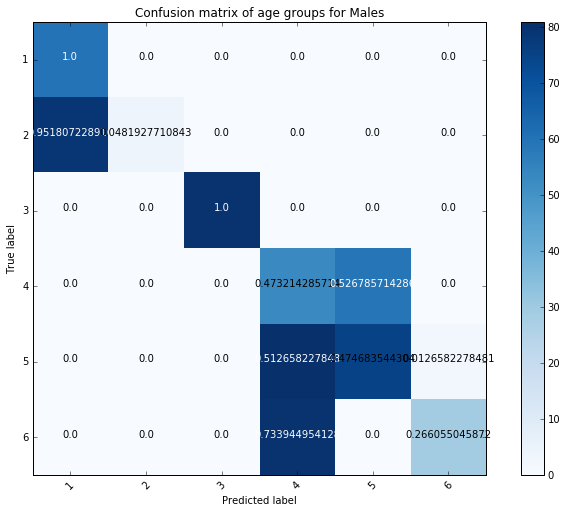

In [66]:
# Plot Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X, y, test_size=0.973)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_M,y_train_M)
      
y_pred_M = clf.predict(X_test_M)

cnf_matrix = confusion_matrix(y_test_M, y_pred_M)
class_names = np.array(['1','2','3','4','5','6'])

np.set_printoptions(precision=2)

plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix of age groups for Males', normalize = True)
plt.show()

Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.18  0.82  0.    0.    0.    0.  ]
 [ 0.    0.47  0.36  0.17  0.    0.  ]
 [ 0.    0.    0.52  0.48  0.    0.  ]
 [ 0.    0.    0.08  0.16  0.76  0.  ]
 [ 0.    0.    0.    0.    0.14  0.86]]


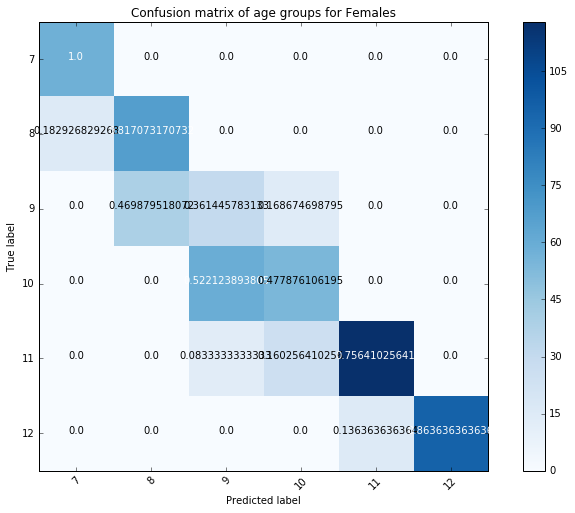

In [61]:
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X, y, test_size=0.973)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_F,y_train_F)

y_pred_F = clf.fit(X_train_F, y_train_F).predict(X_test_F)

cnf_matrix = confusion_matrix(y_test_F, y_pred_F)
class_names = np.array(['7','8','9','10','11','12'])

np.set_printoptions(precision=2)

plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix of age groups for Females', normalize = True)
plt.show()

In [ ]:
train_lda = train_lda.merge(phone[['device_id','brand']],on='device_id',how = 'inner')
train_lda.head()

In [ ]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
phone.head()

In [ ]:
train_lda = gatrain.merge(freq_geo,on='device_id',how='inner').drop_duplicates()
train_lda = train_lda[['geohashes_int','freq','traj_len_km','device_id','event_id','gender_y','age_y','group_y','timestamp']].merge(deviceapps, on = 'device_id', how = 'inner').drop_duplicates()
train_lda.head()

In [ ]:
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))
# gatrain['trainrow'] = np.arange(gatrain.shape[0])
# gatest['testrow'] = np.arange(gatest.shape[0])
#Encode apps
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(freq_geo[['event_id','device_id','traj_len_km','geohashes_int','freq']], how='inner',on='event_id')
                             .groupby(['device_id','app'])['app'].agg(['size'])
                             .reset_index())
deviceapps['device_id']=deviceapps.device_id.map(lambda x: int(x))
deviceapps.head()

In [ ]:
# Including additional features : app, size, brand
lda_features = train_lda[['geohashes_int','device_id','traj_len_km','freq','event_id','app','size','brand','gender_y']]
X = lda_features.values
y = np.array(lda_features['gender_y'].tolist())
test_size = np.arange(0.1,0.8,0.1)
print('Features Selected:\n',lda_features.columns[0:len(lda_features.columns)-1])
print('\nClass Labels: Male=0, Female = 1')
# Invoke LDA model from scikit-learn 
clf = LDA(store_covariance = True,solver ='lsqr',shrinkage = None)
for i in test_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state = 0)
    # Fit the data to LDA model
    fit = clf.fit(X_train,y_train)
    # Covariance matrix (shared by all classes)
    #cov_mat = fit.covariance_
    # Predict confidence scores for samples.
    decision_func = fit.decision_function(X_test)
    print('\ntrain_test_split = ',(1-i)*100,':',i*100)
    #print('\nModel Parameters:',clf.get_params(deep=True))
    print('\nPredicted Classes: ',clf.predict(X_test))
    print('\nModel Score:',fit.score(X_test,y_test))

In [ ]:
# Including additional features : app, size, brand
lda_features = train_lda[['geohashes_int','device_id','traj_len_km','freq','event_id','app','size','brand','age_y','gender_y','group_y']]
X = lda_features.values
y = np.array(lda_features['group_y'].tolist())
test_size = np.arange(0.1,0.8,0.1)
print('Features Selected:\n',lda_features.columns[0:len(lda_features.columns)-1])
print('\nClass Labels: Age')
# Invoke LDA model from scikit-learn 
clf = LDA(store_covariance = True,solver ='lsqr',shrinkage = None)
for i in test_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state = 0)
    # Fit the data to LDA model
    fit = clf.fit(X_train,y_train)
    # Covariance matrix (shared by all classes)
    #cov_mat = fit.covariance_
    # Predict confidence scores for samples.
    decision_func = fit.decision_function(X_test)
    print('\ntrain_test_split = ',(1-i)*100,':',i*100)
    #print('\nModel Parameters:',clf.get_params(deep=True))
    print('\nPredicted Classes: ',clf.predict(X_test))
    print('\nModel Score:',fit.score(X_test,y_test))

In [ ]:
# Including features : geohash, device_id, event_id, traj_len,freq
lda_features = pd.read_csv('formatted_freqItemSets_train.csv')
lda_features['geohash_int'] = lda_features.geohash.apply(lambda x: geohash.base32_to_int(x))
X = lda_features[['geohash_int','device_id','freq','age','gender', 'group']].values
y = np.array(lda_features['gender'].tolist())
test_size = np.arange(0.10,0.7,0.10)
test_set,score=[],[]
#print('Features Selected:',lda_features.columns[0:len(lda_features.columns)-1])
#print('\nClass Labels: Male=0, Female = 1')
clf = LDA(store_covariance = False,solver ='lsqr')
for i in test_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state = 0)
    # Fit the data to LDA model
    fit = clf.fit(X_train,y_train)
    # Covariance matrix (shared by all classes)
    #cov_mat = fit.covariance_
    # Predict confidence scores for samples.
    decision_func = fit.decision_function(X_test)
    #print('\ntrain_test_split = ',(1-i)*100,':',i*100)
    #print('\nModel Parameters:',clf.get_params(deep=True))
    #print('\nPredicted Classes: ',clf.predict(X_test))
    #print('\nModel Score:',fit.score(X_test,y_test))
    score.append(fit.score(X_test,y_test))
    test_set.append(i)

test_set = np.array(test_set)*100
score = np.array(score)
xnew = np.linspace(test_set.min(),test_set.max(),300)
power_smooth = spline(test_set,score,xnew)
plt.plot(xnew,power_smooth,'k-',lw=4)
plt.xlabel('Size of Test dataset(%)')
plt.ylabel('Score')
#plt.title('Variation of LDA model score with changing test data\n')
plt.show()

In [ ]:
np.array(score)